In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# 데이터를 불러오는 가정된 코드입니다. 실제 파일 경로로 바꿔주세요.
df = pd.read_csv( r'C:\Users\bjh24\notebook\business.csv')

# 불필요한 열 제거
df.drop(['ch_code', 'num_code'], axis=1, inplace=True)

# 날짜 및 시간 데이터 처리
df['dep_time'] = pd.to_datetime(df['dep_time']).dt.hour  # 시간만 추출
df['arr_time'] = pd.to_datetime(df['arr_time']).dt.hour  # 시간만 추출

# 비행 시간을 분 단위로 변환
df['time_taken'] = pd.to_timedelta(df['time_taken']).dt.total_seconds() / 60

# 범주형 데이터 인코딩
categorical_features = ['airline', 'stop', 'to']
numerical_features = ['dep_time', 'arr_time', 'time_taken']

# 전처리기 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

df['price'] = df['price'].replace(',', '', regex=True).astype(float)

# 데이터 분할
X = df.drop('price', axis=1)
y = df['price']    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 정의
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100)
}

# 모델 훈련 및 평가
for name, model in models.items():
    # 파이프라인 생성
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    
    # 모델 훈련
    pipeline.fit(X_train, y_train)
    
    # 예측
    y_pred = pipeline.predict(X_test)
    
    # 성능 평가
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    print(f'{name} RMSE: {rmse}')


Linear Regression RMSE: 9394.240698607418
Decision Tree RMSE: 4863.578470362008
Random Forest RMSE: 4838.080477174881
Gradient Boosting RMSE: 8357.980018651679


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 데이터를 불러오는 코드입니다. 실제 파일 경로로 바꿔주세요.
df = pd.read_csv(r'C:\Users\bjh24\notebook\business.csv')

# 날짜 데이터를 수치형으로 변환합니다.
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')  # '일-월-년' 형식으로 날짜 변환
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df.drop('date', axis=1, inplace=True)

def convert_time_to_minutes(time_str):
    if pd.isna(time_str):
        return 0
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes

df['dep_time'] = df['dep_time'].apply(convert_time_to_minutes)
df['arr_time'] = df['arr_time'].apply(convert_time_to_minutes)

def convert_duration_to_minutes(duration_str):
    if pd.isna(duration_str):
        return 0
    hours, minutes = duration_str.replace('h', '').replace('m', '').split()
    return int(hours) * 60 + int(minutes)

df['time_taken'] = df['time_taken'].apply(convert_duration_to_minutes)


# 카테고리형 데이터를 수치형으로 변환합니다.
categorical_features = ['airline', 'stop', 'to']
numerical_features = ['year', 'month', 'day', 'dep_time', 'arr_time', 'time_taken']

# 전처리기 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# 모델 파이프라인 정의
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor())])

# 특성과 타겟 변수를 분리합니다.
X = df.drop('price', axis=1)
y = df['price'].replace(',', '', regex=True).astype(float)

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델을 훈련합니다.
model.fit(X_train, y_train)

# 예측을 수행합니다.
y_pred = model.predict(X_test)

# RMSE를 계산합니다.
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Random Forest RMSE: {rmse}')


Random Forest RMSE: 4488.271736672858


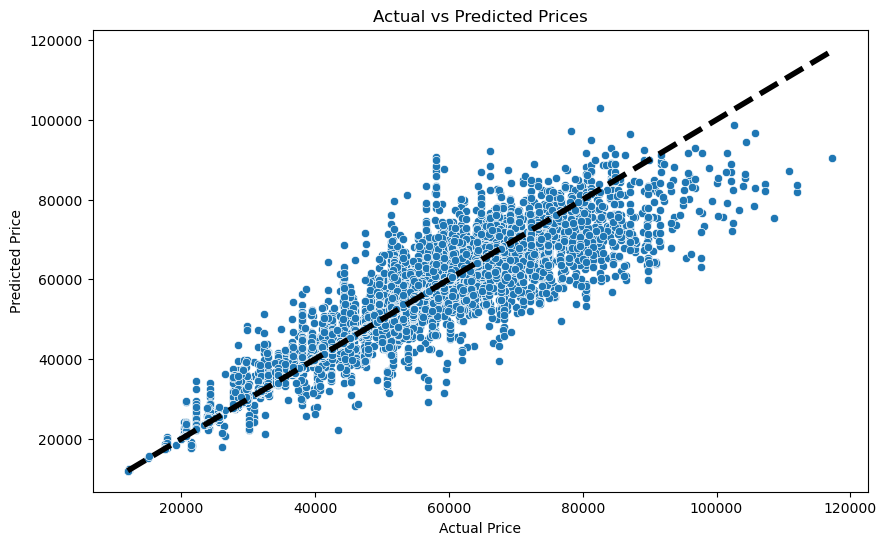

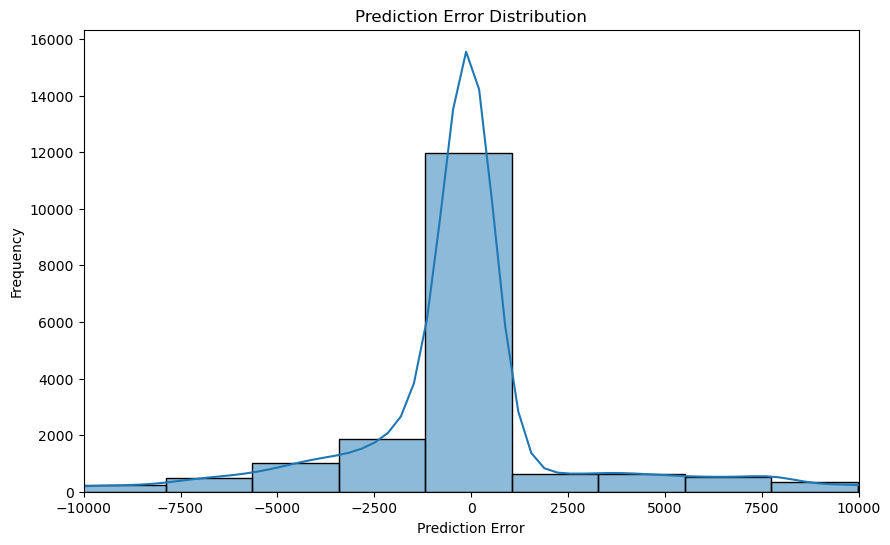

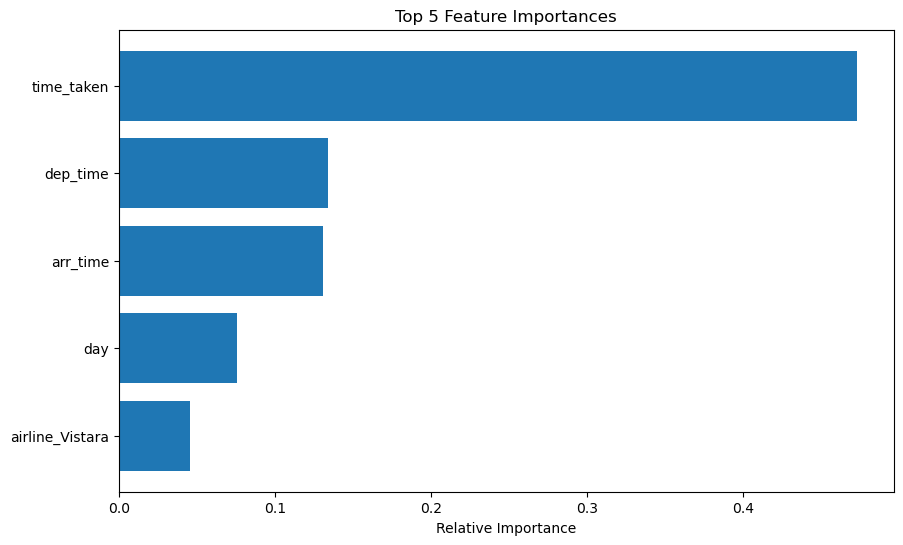

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 실제 값과 예측 값을 비교하는 산점도 그래프
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

# 예측 오류 분포 시각화
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.xlim(-10000, 10000)  # x축 범위를 -10000에서 10000 사이로 설정합니다.
plt.show()


# 특성 중요도 시각화
if 'regressor' in model.named_steps:
    regressor = model.named_steps['regressor']
    importances = regressor.feature_importances_
    # 파이프라인 내 전처리기를 통해 처리된 특성 이름을 얻습니다.
    feature_names = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
    feature_names = numerical_features + list(feature_names)
    indices = np.argsort(importances)

      # 상위 5개 특성만 시각화합니다.
top_n = 5
sorted_idx = np.argsort(importances)[-top_n:]
plt.figure(figsize=(10, 6))
plt.title('Top 5 Feature Importances')
plt.barh(range(top_n), importances[sorted_idx], align='center')
plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx])
plt.xlabel('Relative Importance')
plt.show()

